# <center> Neural Networks and Deep Learning (CSCI 5922)</center>
# <center> Spring 2020 </center>

**Name:** David Young-Jae Kim

## Goal

The goal of this assignment is to introduce neural networks in terms of ideas you are already familiar with:  linear regression and classification

## Dataset

You are given a dataset with 2 input variables ($x_1$, $x_2$) and an output variable ($y$).

In [1]:
from sklearn.datasets import make_regression
from matplotlib import pyplot as plt
import numpy as np
import os
from numpy.linalg import inv

# Load data
data = np.loadtxt(os.path.join('data', 'assign1_data.txt'),  delimiter=',')
X = data[:,:2]
X=np.append(X, np.resize(np.ones(len(X)+1),(-1,1)), axis=1)
y = data[:, 2]
z = data[:, 3]

## Part 1

Write a program to find the exact least squares solution to $y = w_1 x_1 + w_2 x_2 + b$ for the above dataset, using the normal equation.

Complete the following function below and use it to answer questions (A) and (B). 

**Note:** Please do not change the interface of the given function.

In [2]:
def least_squares(X, y):
    """
    Finds the Least Squares solution
    
    Parameters
    ----------
    X : NumPy array of features (size : no of examples X features)
    y : Numpy array of output value 'y' (size : no of examples X 1)
    
    Returns
    -------
    w : solution array
    """
    return np.matmul(np.matmul(inv(np.matmul(X.T,X)),X.T),y)
    #pass

(A) Report the values of $w_1$, $w_2$, and $b$.

In [3]:
w=least_squares(X,y)

print("The values of w1 is",w[0],"w2 is",w[1],"and the bias is",w[2])

The values of w1 is -2.044242595137635 w2 is 3.996860168659326 and the bias is -0.9242908118675917


(B) What function or method did you use to find the least-squares solution?

In this problem we approched it using the general linear regression, we used the equation
$$\beta = (X^TX)^{-1}X^Ty$$

## Part 2

Implement linear regression of y on X via first-order optimization of the least-squares objective. Write a program that determines the coefficients {w1,w2,b}. Implement stochastic gradient descent, batch gradient descent, and mini-batch gradient descent. You will need to experiment with updating rules, step sizes (i.e. learning rates), stopping criteria, etc. Experiment to find settings that lead to solutions with the fewest number of sweeps through the data.

Complete the following functions below and use them to answer questions (A), (B) and (C). You may find the shuffle function from scikit-learn useful. 

Use the following hyperparameters:

Learning rates = [0.001, 0.05, 0.01, 0.05, 0.1, 0.3]

MaxIter = [10, 50, 100, 500, 1000, 5000, 10000, 25000, 50000]

**Note:** Please do not change the interface of the given functions.

In [4]:
from sklearn.utils import shuffle

# function that returns a TRUE value if the error difference is smaller than a certain error rate
def error_difference(before_error,current_error):
    if before_error == 0:
        return False
    error_rate = 0.0001
    return abs(current_error - before_error) / before_error <= error_rate

# function to compute hypothesis / predictions 
def predictions(X, w): 
    return np.dot(X, w) 
  
# function to compute gradient of error function w.r.t. weight w 
def gradient(X, y, w): 
    grad = np.dot(X.T, (predictions(X, w) - y)) 
    return grad 
  
# function to compute the error for current values of weight w
def R(X, y, w):
    return (1/len(y))*((predictions(X,w) - y)**2).sum()

def online_epoch(X, y, w, alpha):
    """
    One epoch of stochastic gradient descent (i.e. one sweep of the dataset).
    
    Parameters
    ----------
    X : NumPy array of features (size : no of examples X features)
    y : Numpy array of class labels (size : no of examples X 1)
    w : array of coefficients from the previous iteration
    
    Returns
    -------
    Coefficients of the model (after updating)
    """
    error = 0
    
    for i in range(len(y)):
        w = w - alpha * (np.dot(w,X[i]) - y[i]) * X[i]
        error += R(X, y, w)
    
    error /= len(y)
    
    return error, w
    #pass

def batch_update(X, y, w, alpha):
    """
    One iteration of full-batch gradient descent.
    
    Parameters
    ----------
    X : NumPy array of features (size : no of examples X features)
    y : Numpy array of class labels (size : no of examples X 1)
    w : array of coefficients from the previous iteration
    
    Returns
    -------
    Coefficients of the model (after updating)
    """
    w = w - alpha * (1/len(y)) * gradient(X, y, w)
    
    return R(X, y, w), w 
    #pass

def mini_batch_update(X, y, w, alpha, batch_size):
    """
    One epoch of mini-batch SGD over the entire dataset (i.e. one sweep of the dataset).
    
    Parameters
    ----------
    X : NumPy array of features (size : no of examples X features)
    y : Numpy array of class labels (size : no of examples X 1)
    w : array of coefficients from the previous iteration
    batch_size : size of the batch for gradient update
    
    Returns
    -------
    Coefficients of the model (after updating)
    """
    mini_batch_error = 0
    for i in range(0, len(y), batch_size):
        if i+batch_size < len(y):
            w = w - alpha * (1/batch_size) * gradient(X[i:i+batch_size], y[i:i+batch_size], w)
            error = R(X[i:i+batch_size], y[i:i+batch_size], w)
        else:
            w = w - alpha * (1/batch_size) * gradient(X[i:], y[i:], w)
            error = R(X[i:], y[i:], w)
        mini_batch_error += error
    return mini_batch_error / (len(y) / batch_size), w
    #pass

def least_squares_grad_desc(X, y, maxIter, alpha, update, *batch_size):
    """
    Implements least squares with gradient descent.
    
    Parameters
    ----------
    X : NumPy array of features (size : no of examples X features)
    y : Numpy array of class labels (size : no of examples X 1)
    maxIter : Maximum number of iterations allowed
    alpha : Learning rate
    update : update function to utilize (one of online, batch, mini-batch)
    batch_size : number of examples in a batch (only useful when update = mini_batch_update)
    
    Returns
    -------
    Coefficients of the model (after updating)
    
    Note : *batch_size is an optional argument and only to be used when doing mini-batch Gradient Descent 
    """
    error_list=[float('inf')]
    w = np.random.rand(len(X[0]))
    for i in range(maxIter):
        X, y = shuffle(X, y)
        if update == mini_batch_update:
            error,w = update(X, y, w, alpha, batch_size[0])
        else:
            error,w = update(X, y, w, alpha)
        
        error_list.append(error)
        if i>2 and error_difference(error_list[-2],error_list[-1]):
            return error_list,w
    return error_list , w
    #pass

(A) Report the values of $w_1$, $w_2$, and $b$. 

In [5]:
Learning_rates = [0.001, 0.05, 0.01, 0.05, 0.1, 0.3]
MaxIter = [10, 50, 100, 500, 1000, 5000, 10000, 25000, 50000]

for l in Learning_rates:
    for m in MaxIter:
        error_list, w = least_squares_grad_desc(X, y, m, l, online_epoch)
        print("For Learning rate of "+str(l)+" and iteration of "+str(m)+" we get "+str(w)+" with error "+str(error_list[-1]))

For Learning rate of 0.001 and iteration of 10 we get [-0.27386466  0.78169255  0.14156595] with error 1.0949981166958032
For Learning rate of 0.001 and iteration of 50 we get [-0.31921414  1.34634569 -0.39460331] with error 0.7344918111968546
For Learning rate of 0.001 and iteration of 100 we get [-0.79041832  1.86198411 -0.43458447] with error 0.4675913095284818
For Learning rate of 0.001 and iteration of 500 we get [-1.98631233  3.83833025 -0.87105665] with error 0.04146307517803449
For Learning rate of 0.001 and iteration of 1000 we get [-2.00873819  3.89256611 -0.88806147] with error 0.040294781282665504
For Learning rate of 0.001 and iteration of 5000 we get [-2.00169706  3.91178986 -0.90120036] with error 0.04005542353688792
For Learning rate of 0.001 and iteration of 10000 we get [-2.00291868  3.90874726 -0.89929836] with error 0.04008893858172526
For Learning rate of 0.001 and iteration of 25000 we get [-1.995682    3.89812963 -0.89722796] with error 0.04027148164581254
For Le

In [6]:
for l in Learning_rates:
    for m in MaxIter:
        error_list, w = least_squares_grad_desc(X, y, m, l, batch_update)
        print("For Learning rate of "+str(l)+" and iteration of "+str(m)+" we get "+str(w)+" with error "+str(error_list[-1]))

For Learning rate of 0.001 and iteration of 10 we get [0.11740323 0.29102687 0.17774428] with error 1.400596999640624
For Learning rate of 0.001 and iteration of 50 we get [0.22201611 0.35807416 0.54183995] with error 1.8495072461146587
For Learning rate of 0.001 and iteration of 100 we get [ 0.93476486  0.92176334 -0.01806119] with error 1.8738430883229549
For Learning rate of 0.001 and iteration of 500 we get [-0.06040703  0.76675195  0.01250341] with error 1.108484619032766
For Learning rate of 0.001 and iteration of 1000 we get [0.16547169 0.35356903 0.04318701] with error 1.3388227739071186
For Learning rate of 0.001 and iteration of 5000 we get [-0.55143351  0.93500098 -0.07526389] with error 0.8547356598641989
For Learning rate of 0.001 and iteration of 10000 we get [-0.94315894  1.81241739 -0.33605719] with error 0.45887007205889746
For Learning rate of 0.001 and iteration of 25000 we get [-1.39662465  2.87404784 -0.66069008] with error 0.15612806343301067
For Learning rate of 

In [7]:
for l in Learning_rates:
    for m in MaxIter:
        error_list, w = least_squares_grad_desc(X, y, m, l, mini_batch_update, 10)
        print("For Learning rate of "+str(l)+" and iteration of "+str(m)+" we get "+str(w)+" with error "+str(error_list[-1]))

For Learning rate of 0.001 and iteration of 10 we get [0.70210534 0.12186812 0.25467481] with error 1.894346121704023
For Learning rate of 0.001 and iteration of 50 we get [0.0798167  0.59994087 0.33211076] with error 1.4861708362690507
For Learning rate of 0.001 and iteration of 100 we get [-0.21167035  0.91083088 -0.03224149] with error 0.9863003236190415
For Learning rate of 0.001 and iteration of 500 we get [-0.77239635  1.64143953 -0.3296241 ] with error 0.5396065687334973
For Learning rate of 0.001 and iteration of 1000 we get [-1.06157213  1.97193694 -0.36097229] with error 0.39564213816413246
For Learning rate of 0.001 and iteration of 5000 we get [-1.91417967  3.6479119  -0.8085638 ] with error 0.04935192978759131
For Learning rate of 0.001 and iteration of 10000 we get [-1.85787396  3.63176853 -0.82709223] with error 0.051178808789552666
For Learning rate of 0.001 and iteration of 25000 we get [-1.83389206  3.66446347 -0.85509251] with error 0.050102952662488265
For Learning 

(B) What settings worked well for you:  online vs. batch vs. minibatch? What step size? How did you decide to terminate?

### Online vs. batch vs. minibatch
Since we do not have any held out data for this experiment, we assume that the lowest training data error is the best model. Based on that assumption.

The following settings worked well for each type of update:

1. Online update
    - step size = $0.01$ (alpha)
    - error = ~$0.039$
    
2. Batch update
    - step size = $0.3$ (alpha)
    - error = ~$0.039$

3. Minibatch update
    - step size = $0.3$ (alpha)
    - error = ~$0.036$


### What step size
It seems that when we do (mini)batch update a relatively large step size is required. I assume this is because when we do batch update we have a more stable gradient then online update. Thus, we can have a larger step size.

### How did you decide to terminate
Decided to terminate when the absolute change in the error is less then $0.01\%$


*In the below graph I set the parameters to the same step size and iteration so we can compare the three.
According to the graph data in __(C)__ we can see that:
- __Online Update__ converges fastest, __Batch Update__ converges slowest. This is by looking at the graph not the number of epochs, the number of epochs is dependent on how I define to terminate
- __Minibatch Update__ gives the least error, __Online Update__ gives the most. This is based on the error rate  that is being reported.

(C) Make a graph of error on the entire data set as a function of epoch. An epoch is a complete sweep through all the data (which is one iteration for full-batch gradient descent).

maxIter = 50000, no. of epochs = 44 , error = 0.04189286210164008


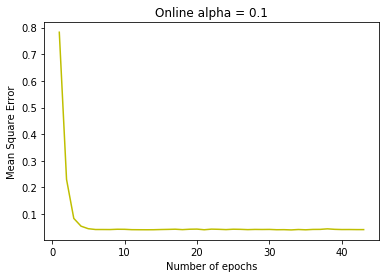

maxIter = 50000, no. of epochs = 640 , error = 0.03970893577590363


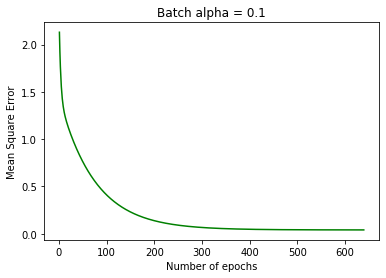

maxIter = 50000, no. of epochs = 117 , error = 0.038618258883733034


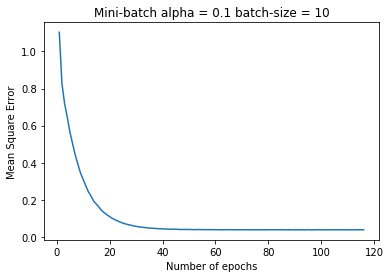

In [8]:
# ONLINE

maxIter = 50000
alpha = 0.1
error_list,w=least_squares_grad_desc(X, y, maxIter, alpha, online_epoch)
print ("maxIter = 50000, no. of epochs =", len(error_list), ", error =", error_list[-1])

plt.plot([i for i in range(len(error_list))], error_list, 'y')
plt.title('Online alpha = 0.1')
plt.xlabel('Number of epochs')
plt.ylabel('Mean Square Error')
plt.show()


# BATCH

maxIter = 50000
alpha = 0.1
error_list,w=least_squares_grad_desc(X, y, maxIter, alpha, batch_update)
print ("maxIter = 50000, no. of epochs =", len(error_list), ", error =", error_list[-1])

plt.plot([i for i in range(len(error_list))], error_list, 'g')
plt.title('Batch alpha = 0.1')
plt.xlabel('Number of epochs')
plt.ylabel('Mean Square Error')
plt.show()

# MINI-BATCH

maxIter = 50000
alpha = 0.1
error_list,w=least_squares_grad_desc(X, y, maxIter, alpha, mini_batch_update, 10)
print ("maxIter = 50000, no. of epochs =", len(error_list), ", error =", error_list[-1])

plt.plot([i for i in range(len(error_list))], error_list)
plt.title('Mini-batch alpha = 0.1 batch-size = 10')
plt.xlabel('Number of epochs')
plt.ylabel('Mean Square Error')
plt.show()

## Part 3

The data set from a regression problem can be converted into a classification problem simply by using the sign of (+ or -) as representing one of two classes. In the data set used in Part 1 and 2, you'll see the variable z that represents this binary (0 or 1) class.

Use the perceptron learning rule to solve for the coefficients {$w_1$, $w_2$, $b$} of this classification problem.   

Two warnings: First, your solution to Part 3 should require only a few lines of code changed from the code you wrote for Part 2. Second, the Perceptron algorithm will not converge if there is no exact solution to the training data. It will jitter among coefficients that all yield roughly equally good solutions.

Complete the following functions below and use them to answer questions (A) and (B). 

**Note:** Please do not change the interface of the given functions.

In [9]:
def change_y_values(y):
    y_ = np.copy(y)
    for i in range(len(y_)):
        if y_[i] == 0:
            y_[i] = -1
    return y_

def perceptron_update(X, y, w, alpha):
    """
    One epoch of Perceptron updates (full sweep of the dataset).
    
    Parameters
    ----------
    X : NumPy array of features (size : no of examples X features)
    y : Numpy array of class labels (size : no of examples X 1)
    w : array of coefficients from the previous iteration
    
    Returns
    -------
    w : Coefficients of the classifier (after updating)
    incorrect : Incorrectly classified examples
    """
    y_ = change_y_values(y)
    incorrect = 0
    
    for i in range(len(y)):
        if y_[i] * np.dot(X[i],w) < 0:
            w += alpha*y_[i]*X[i]
            incorrect += 1
    
    return w,incorrect
            
    #pass

def perceptron(X, y, maxIter, alpha):
    """
    Implements the Perceptron algorithm.
    
    Parameters
    ----------
    X : NumPy array of features (size : no of examples X features)
    y : Numpy array of class labels (size : no of examples X 1)
    maxIter : The maximum number of iterations allowed 
    alpha : Learning Rate
    
    Returns
    -------
    w : Coefficients of the classifier
    incorrect : Incorrectly classified examples on termination
    """
    incorrect_list=[]
    w = np.random.rand(len(X[0]))
    for i in range(maxIter):
        X, y = shuffle(X, y)
        w, incorrect = perceptron_update(X, y, w, alpha)
        if i>200 and error_difference(incorrect_list[-1],incorrect):
            return w, incorrect_list
        incorrect_list.append(incorrect)
    return w,incorrect_list
    #pass

(A) Report the values of coefficients $w_1$, $w_2$, and $b$.

In [10]:
w, incorrect_list = perceptron(X, z, 1000, 0.01)
print ("w1 =", w[0])
print ("w2 =", w[1])
print ("b =", w[2])
print ("Incorrect examples:", incorrect_list[-1])

w1 = -0.2040116810411209
w2 = 0.3164602160423371
b = -0.03477364963554747
Incorrect examples: 3


(B) Make a graph of the accuracy (% correct classification) on the training set as a function of epoch.

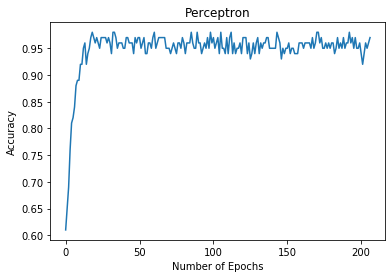

In [11]:
accuracy = 1.0 - (np.array(incorrect_list) / len(z))

plt.title("Perceptron")
plt.xlabel("Number of Epochs")
plt.ylabel("Accuracy")
plt.plot([i for i in range(len(incorrect_list))], accuracy)
plt.show()

## Part 4

In machine learning, we really want to train a model based on some data and then expect the model to do well on "out of sample" data. Try this with the code you wrote for Part 3:  Train the model on the first {5, 10, 25, 50, 75} examples in the data set and test the model on the final 25 examples.

Complete the following function below and use it to answer (A). 

**Note:** Please do not change the interface of the given function.

In [12]:
def classify(X, y, w):
    """
    Use this function to classify examples in the test set
    
    Parameters
    ----------
    X : Test set features
    y : Test set labels
    w : Perceptron coefficients
    
    Returns
    -------
    correct : number of correctly classified examples
    """
    correct = 0
    
    y_ = change_y_values(y)
    
    for i in range(len(y)):
        if y_[i] * np.dot(X[i],w) > 0:
            correct += 1
    
    return correct
    #pass

How does performance on the test set vary with the amount of training data? Make a bar graph showing performance for each of the different training set sizes.

The correct percentage is: [0.68, 0.72, 0.92, 0.96, 0.96]


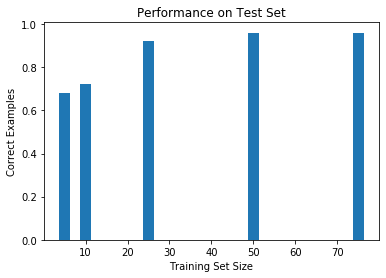

In [13]:
train_sets = [5, 10, 25, 50, 75]
correct_list = []
X_test = X[-25:]
z_test = z[-25:]
for train_set in train_sets:
    X_train = X[:train_set]
    z_train = z[:train_set]
    w, incorrect = perceptron(X_train, z_train, 1000, 0.001)
    correct = classify(X_test, z_test, w)
    correct_list.append(correct / len(z_test))
print("The correct percentage is:",correct_list)
plt.bar(train_sets, correct_list, width=2.5)
plt.xlabel("Training Set Size")
plt.ylabel("Correct Examples")
plt.title("Performance on Test Set")

plt.show()

Usually the performance increase as the number of training data increases. However, at a certain point no matter how many training set we increase the performance saturates. This could be because the additional training set doesn't give any additional information about finding the optimal decision boundary, or it could be that this is the best result with the latent structure of the data